In [20]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [21]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [3]:
data_path = os.path.join('TrashData')
actions = np.array(['hello', 'thanks', 'eat', 'help', 'goodbye', 'no', 'yes', 'please', 'sorry', 'what'])
no_sequences = 30
sequence_length = 30

for action in actions:
    for sequence in range(1, no_sequences + 1):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except FileExistsError:
            pass

In [4]:
ls /dev/video*

/dev/video0  /dev/video1


In [5]:
#2? sheesh! index 1 doesn't work

In [6]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(1, no_sequences + 1):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()


I0000 00:00:1717499252.860692   31129 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717499252.866377   52676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.1.0-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717499252.953451   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.964962   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.968855   52666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717499252.968855   52667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature i

In [22]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

no_sequences = 30
sequence_length = 30

data_path = 'TrashData'
actions = np.array(['hello', 'thanks', 'eat', 'help', 'goodbye', 'no', 'yes', 'please', 'sorry', 'what'])

label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(1, no_sequences + 1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Shape of sequences: {sequences.shape}")
print(f"Shape of labels: {labels.shape}")

sequence_length = sequences.shape[1]  # bruhh ~30
keypoints_size = sequences.shape[2]   # 1662

# (samples, sequence_length, keypoints_size, 1)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(actions))
y_test = to_categorical(y_test, num_classes=len(actions))

X_train = X_train.reshape(-1, sequence_length, keypoints_size, 1)
X_test = X_test.reshape(-1, sequence_length, keypoints_size, 1)

print("Shape of:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")


Shape of sequences: (300, 30, 1662)
Shape of labels: (300,)
Shape of:
X_train: (240, 30, 1662, 1)
X_test: (60, 30, 1662, 1)
y_train: (240, 10)
y_test: (60, 10)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, InputLayer, Conv1D, MaxPooling1D

sequence_length = 30
keypoints_size = 1662  # size(keypoints) after flattening

model = Sequential([
    InputLayer(input_shape=(sequence_length, keypoints_size, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 1662, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 831, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 831, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 415, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 415, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 207, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 79488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,087,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,180,618 (19.76 MB)

 Trainable params: 5,180,618 (19.76 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
print(f"Sequences shape: {sequences.shape}")

print(f"Total elements: {sequences.size}")

Sequences shape: (300, 30, 1662)
Total elements: 14958000


In [25]:
sequences = sequences.reshape(sequences.shape[0], sequences.shape[1], sequences.shape[2], 1)

print(f"Sequences after reshaping: {sequences.shape}")


Sequences after reshaping: (300, 30, 1662, 1)


In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

sequences = sequences.reshape((sequences.shape[0], 30, 1662, 1))

labels = to_categorical(labels, num_classes=len(actions))

X+train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
print("Shapes of:")
print()
print(f"X_train:\t{X_train.shape}")
print(f"X_test:\t\t{X_test.shape}")
print(f"y_train:\t{y_train.shape}")
print(f"y_test:\t\t{y_test.shape}")


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


Shapes of:

X_train:	(240, 30, 1662, 1)
X_test:		(60, 30, 1662, 1)
y_train:	(240, 10)
y_test:		(60, 10)
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 821ms/step - accuracy: 0.1040 - loss: 2.7418 - val_accuracy: 0.1500 - val_loss: 2.3016
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 770ms/step - accuracy: 0.0755 - loss: 2.3049 - val_accuracy: 0.0500 - val_loss: 2.3045
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 692ms/step - accuracy: 0.1284 - loss: 2.2996 - val_accuracy: 0.0500 - val_loss: 2.3358
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 679ms/step - accuracy: 0.1133 - loss: 2.3071 - val_accuracy: 0.0833 - val_loss: 2.3080
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 710ms/step - accuracy: 0.1381 - loss: 2.2998 - val_accuracy: 0.0500 - val_loss: 2.3295
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 729ms/step - accuracy: 0.1055 - loss: 2.2934 - val_accuracy: 0.0500 - val_loss: 2.3176
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.1065 - loss: 2.2875 - val_accuracy: 0.0667 - val_loss: 2.3094
Epoch 8/50
8/8

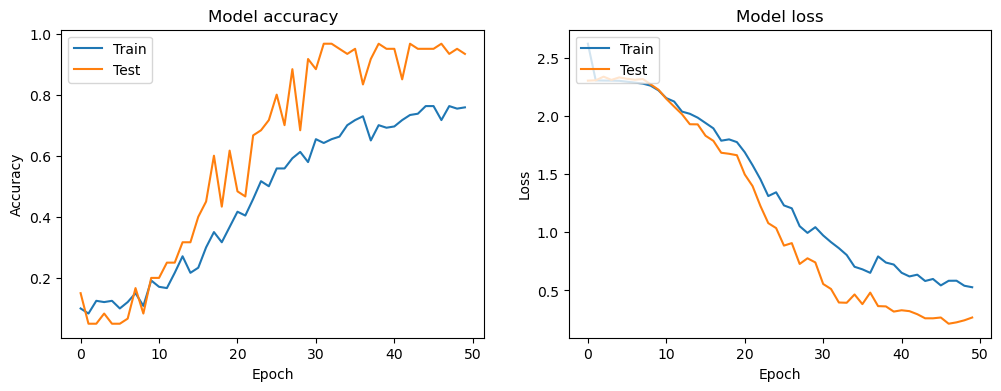

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [28]:
predictions = model.predict(X_test)
predicted = np.argmax(predictions, axis=1)
forReal = np.argmax(y_test, axis=1)

print(f"Predicted:\t{predicted}")
print(f"For Real:\t{forReal}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Predicted:	[6 8 5 0 7 7 6 3 0 5 7 1 7 1 6 7 9 7 4 5 2 3 8 8 3 1 9 8 5 7 0 5 1 0 7 4 0
 2 1 2 3 2 9 1 2 2 7 7 3 7 6 4 7 2 9 9 3 3 6 0]
For Real:	[6 8 5 0 7 7 6 3 0 5 7 1 7 1 6 7 9 7 4 5 2 3 8 8 3 1 9 9 5 7 0 5 1 0 7 3 0
 3 1 2 3 2 9 2 2 2 7 7 3 7 6 4 7 2 9 9 3 3 6 0]


In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [31]:
_ = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


In [32]:
real = np.argmax(y_test, axis=1).tolist()
predict = np.argmax(_, axis=1).tolist()

In [33]:
multilabel_confusion_matrix(real, predict)

array([[[54,  0],
        [ 0,  6]],

       [[54,  1],
        [ 0,  5]],

       [[52,  1],
        [ 1,  6]],

       [[51,  0],
        [ 2,  7]],

       [[57,  1],
        [ 0,  2]],

       [[55,  0],
        [ 0,  5]],

       [[55,  0],
        [ 0,  5]],

       [[48,  0],
        [ 0, 12]],

       [[56,  1],
        [ 0,  3]],

       [[54,  0],
        [ 1,  5]]])

In [34]:
accuracy_score(real, predict)

0.9333333333333333

In [10]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        if keypoints.size == 1662:
            keypoints = np.expand_dims(keypoints, axis=0)
            keypoints = np.repeat(keypoints, 30, axis=0)
            keypoints = keypoints.reshape(1, 30, 1662, 1)
        else:
            raise ValueError(f"Fuck it! Expected 1662 keypoints, but got {keypoints.size}")
        
        print(f"keypoints sahpe: {keypoints.shape}")
        
        predictions = model.predict(keypoints)
        predicted_class = actions[np.argmax(predictions)]
        
        cv2.putText(image, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/radeonsi_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/zink_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/swrast_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libs

keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/cv2/qt/plugins"
QObject::moveToThread: Current thread (0xa17bc60) is not the object's thread (0x8a72790).
Cannot move to target thread (0xa17bc60)

QObject::moveToThread: Current thread (0xa17bc60) is not the object's thread (0x8a72790).
Cannot move to target thread (0xa17bc60)

QObject::moveToThread: Current thread (0xa17bc60) is not the object's thread (0x8a72790).
Cannot move to target thread (0xa17bc60)

QObject::moveToThread: Current thread (0xa17bc60) is not the object's thread (0x8a72790).
Cannot move to target thread (0xa17bc

keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
keypoints sahpe: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22